
# The importance of space
Agent based models are useful when the aggregate system behavior emerges out of local interactions amongst the agents. In the model of the evolution of cooperation, we created a set of agents and let all agents play against all other agents. Basically, we pretended as if all our agents were perfectly mixed. In practice, however, it is much more common that agents only interact with some, but not all, other agents. For example, in models of epidemiology, social interactions are a key factors. Thus, interactions are dependend on your social network. In other situations, our behavior might be based on what we see around us. Phenomena like fashion are at least partly driven by seeing what others are doing and mimicking this behavior. The same is true for many animals. Flocking dynamics as exhibited by starling, or shoaling behavior in fish, can be explained by the animal looking at its neirest neighbors and staying within a given distance of them. In agent based models, anything that structures the interaction amongst agents is typically called a space. This space can be a 2d or 3d space with euclidian distances (as in models of flocking and shoaling), it can also be a grid structure (as we will show below), or it can be a network structure. 

MESA comes with several spaces that we can readily use. These are

* **Grid** Think of this of an excel like space.In this course, we use the new experimental cell spaces. With these, Mesa distinguishes between 3 types of grids: `OrthogonalMooreGrid`, `OrthogonalVonNeumanGrid`, and `HexGrid`. A moore grid is an excel like grid where each cell has 8 neighbors. A OrthogonalVonNeumanGrid were each cell has 4 neighbors, and a HexGrid which is a Catan like grid were each cell has 6 neighbors.
* **ConinuousSpace;** a 2d continous space were agents can occupy any coordinate
* **Network;** a network structure were one or more agents occupy a given node.

A key concern when using a none-networked space, is to think carefull about what happens at the edges of the space. In a basic implementation, agents in for example the top left corner has only 2 neighbors, while an agent in the middle has four neighbors. This can give rise to artifacts in the results. Basically, the dynamics at the edges are different from the behavior further away from the edges. It is therefore quite common to use a torus, or donut, shape for the space. In this way, there is no longer any edge and artifacts are thus removed.


# The emergence of cooperation in space
In this assignment, we'll use an `OrthogonalMooreSpace`. Most of what is covered here translated direclty to the other types of grids. 

We make the following changes to the model

* The model has a grid, with an agent of random class. We initialize the model with equal probabilities for each type of class
* All agents play against their neighbors. On a grid, neighborhood can be defined in various ways. Below, we use a neighborhood distance of 1, and we do include diagonal neighbors (so we use a Moore grid, rather than a von Neumann grid which has 4 neighbors).
* The evolutionary dynamic, after all agents having played, is that each agent compares its scores to its neighbors. It will adopt whichever strategy within its neighborhood performed best.
* Next to using a Grid from MESA, we also use a DataCollector to handle collecting statistics.

Below, I discuss in more detail the code containing the most important modifications


In [1]:
from collections import deque, Counter, defaultdict
from enum import Enum
from itertools import combinations
from math import floor

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mesa import Model, Agent
from mesa.datacollection import DataCollector

from mesa.experimental.cell_space import CellAgent, OrthogonalMooreGrid

class Move(Enum):
    COOPERATE = 1
    DEFECT = 2


class AxelrodAgent(CellAgent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, n_rounds, noise_level=0): 
        super().__init__(model)
        self.n_rounds = n_rounds
        self.points = 0
        self.noise_level = noise_level

    def step(self):
        """Playing the iterated prisoners dilemma agains all other agents in the model"""
        for other in self.cell.neighborhood.agents:
            for _ in range(self.n_rounds):
                move_a = self.move()
                move_b = other.move()
    
                #insert noise in movement, we
                if self.random.random() < self.noise_level:
                    if move_a == Move.COOPERATE:
                        move_a = Move.DEFECT
                    else:
                        move_a = Move.COOPERATE
                if self.random.random() < self.noise_level:
                    if move_b == Move.COOPERATE:
                        move_b = Move.DEFECT
                    else:
                        move_b = Move.COOPERATE                
                
                payoff_a, payoff_b = self.model.payoff_matrix[(move_a, move_b)]
                
                self.receive_payoff(payoff_a, move_a, move_b)
                other.receive_payoff(payoff_b, move_b, move_a)
            self.reset()
            other.reset()

    def move(self):
        """The move to make in this iteration of the game
        
        Returns:
            Move.COOPERATE or Move.DEFECT
        """
        raise NotImplementedError
    
    def receive_payoff(self, payoff, my_move, opponent_move):
        """Receive payoff and moves resulting in that payoff.

        Args:
            payoff : int
            my_move : {Move.COOPERATE, Move.DEFECT}
            opponements_move : {Move.COOPERATE, Move.DEFECT}

        """
        self.points += payoff

    def reset(self):
        """Called after playing N iterations agains another player."""
        raise NotImplementedError


class TitForTat(AxelrodAgent):
    def __init__(self, model, n_rounds, noise_level=0):
        super().__init__(model, n_rounds, noise_level=noise_level)
        self.opponent_last_move = Move.COOPERATE

    def move(self):
        return self.opponent_last_move

    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_move = opponent_move

    def reset(self):
        self.opponent_last_move = Move.COOPERATE


class ContriteTitForTat(AxelrodAgent):
    def __init__(self, model, n_rounds, noise_level=0):
        super().__init__(model, n_rounds, noise_level=noise_level)
        self.opponent_last_two_moves = deque([Move.COOPERATE, Move.COOPERATE], maxlen=2)

    def move(self):
        if (self.opponent_last_two_moves[0] == Move.DEFECT) and (
            self.opponent_last_two_moves[1] == Move.DEFECT
        ):
            return Move.DEFECT
        else:
            return Move.COOPERATE

    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_two_moves.append(opponent_move)

    def reset(self):
        self.opponent_last_two_moves = deque([Move.COOPERATE, Move.COOPERATE], maxlen=2)


class NoisySpatialEvolutionaryAxelrodModel(Model):
    def __init__(
        self,
        n=100,
        noise_level=0.01,
        seed=None,
        height=20,
        width=20,
    ):
        super().__init__(seed=seed)
        self.noise_level = noise_level
        self.num_iterations = n
        
        self.payoff_matrix = {
            (Move.COOPERATE, Move.COOPERATE):(2, 2),
            (Move.COOPERATE, Move.DEFECT): (0, 3),
            (Move.DEFECT, Move.COOPERATE): (3, 0),
            (Move.DEFECT, Move.DEFECT): (1, 1)
        }
        
        self.grid = OrthogonalMooreGrid((width, height), torus=True, capacity=1, random=self.random)
        strategies = AxelrodAgent.__subclasses__()

        for cell in self.grid.all_cells:
            strategy = self.random.choice(strategies)
            agent = strategy(self, self.num_iterations, noise_level=self.noise_level) 
            agent.cell = cell

        # also needed by MESA, and useful for tracking the number of agents for each strategy
        self.datacollector = DataCollector(
            model_reporters={klass.__name__: klass.__name__ for klass in strategies}
        )
        self.count_agent_types()
        self.datacollector.collect(self)

    def count_agent_types(self):
        counter = self.agents.groupby(type).count()
        
        for k, v in counter.items():
            setattr(self, k.__name__, v)

    
    def step(self):
        """Advance the model by one step."""
        self.agents.do("step")
        
        # evolution
        # tricky, we need to determine for each grid cell
        # is a change needed, if so, log position, agent, and type to change to
        agents_to_change = []
        for agent_a in self.agents:
            neigbors = list(agent_a.cell.neighborhood.agents)
            neigbors.sort(key=lambda x: x.points, reverse=True)
            best_strategy = neigbors[0].__class__
            best_score = neigbors[0].points
            
            if best_score > agent_a.points and not isinstance(agent_a, best_strategy):
                agents_to_change.append((agent_a, best_strategy))

        for entry in agents_to_change:
            agent, klass = entry
            cell = agent.cell
            
            # remove agent
            agent.remove()

            new_agent = klass(self, self.num_iterations, noise_level=self.noise_level) 
            new_agent.cell = cell

        self.count_agent_types()
        self.datacollector.collect(self)


/var/folders/_t/l6cr0r0d1m108xdrmrtz7stsb_csl0/T/ipykernel_57124/3750661852.py:13: DeprecationWarning: you are importing from mesa.experimental.cell_space, all cell spaces have been moved to mesa.discrete_space
  from mesa.experimental.cell_space import CellAgent, OrthogonalMooreGrid


In order to visualize and animate this model withint the notebook (see also the first week's tutorial), we need to specify the attributes schedule, grid, and datacollector.


In the `__init__`, we now instantiate an `OrthogonalMooreGrid`, with a specified width and height. We set the kwarg torus to True indicating we are using a donut shape grid to avoid edge effects. Next, we fill this grid with random agents of the different types. This can be implemented in various ways. What I do here is using a list with the different classes (*i.e.*, types of strategies) and draw a random element from this list via `self.random.choice`. So, we iterate over all cells in the grid, for each cell we draw a random strategy class, instantiate the class and assign the cell to it.


```python
    self.grid = OrthogonalMooreGrid((width, height), torus=True, capacity=1, random=self.random)
    strategies = AxelrodAgent.__subclasses__()

    for cell in self.grid.all_cells:
        strategy = self.random.choice(strategies)
        agent = strategy(self, self.num_iterations, noise_level=self.noise_level) 
        agent.cell = cell
```

We also use a DataCollector. This is a default class provided by MESA that can be used for keeping track of relevant statistics. It can store both model level variables as well as agent level variables. Here we are only using model level variables (i.e. attributes of the model). Specifically, we are going to have an attribute on the model for each type of agent strategy (i.e. classes). This attribute is the current count of agents in the grid of the specific type. To implement this, we need to do several things.

1. initialize a data collector instance
2. at every step update the current count of agents of each strategy
3. collect the current counts with the data collector.

For step 1, we set a DataCollector as an attribute. This datacollector needs to know the names of the attributes on the model it needs to collect. So we pass a dict as kwarg to model_reporters. This dict has as key the name by which the variable will be known in the DataCollector. As value, I pass the name of the attribute on the model, but it can also be a function or method which returns a number. Note that the ``klass`` misspelling is deliberate. The word ``class`` is protected in Python, so you cannot use it as a variable name. It is common practice to use ``klass`` instead in the rare cases were you are having variable refering to a specific class.

```python
self.datacollector = DataCollector(model_reporters={klass.__name__:klass.__name__
                                                    for klass in strategies})
```

For step 2, we need to count at every step the number of agents per strategy type. To help keep track of this, we define a new method, `count_agent_types`. The main magic is the use of `setattr` which is a standard python function for setting attributes to a particular value on a given object. This reason for writing our code this way is that we automatically adapt our attributes to the classes of agents we have, rather than hardcoding the agent classes as attributes on our model. If we now add new classes of agents, we don't need to change the model code itself. There is also a ``getattr`` function, which is used by for example the DataCollector to get the values for the specified attribute names. 

```python
def count_agent_types(self):
    counter = self.agents.groupby(type).count()

    for k,v in counter.items():
        setattr(self, k.__name__, v)    

```

We have to add the evolutionary dynamic. This is a bit tricky. In `NoisySpatialEvolutionaryAxelrodModel.step`, we loop over all agents in the model. We check its neighbors and see which strategy performed best. If this is of a different type (``not isinstance(agent_a, best_strategy)``, we add it to a list of agents that needs to be changed and the type of agent to which it needs to be changed. Once we know all agents that need to be changed, we can make this change. 

Making the change is quite straighforward. We first make sure we track the cell to which the agent was assigned. Next, we call `agent.remove()`, this is a default method in MESA for removing agents from the model. Since `AxelrodAgent` subclasses CellAgent, calling `agent.remove` removes the agent not just from the model, but also from our space. Then we can create a new agent of the correct class and assign the now empty cell to this new agent.

```python
# evolution
agents_to_change = []
agents_to_change = []
for agent_a in self.agents:
    neigbors = list(agent_a.cell.neighborhood.agents)
    neigbors.sort(key=lambda x: x.points, reverse=True)
    best_strategy = neigbors[0].__class__
    best_score = neigbors[0].points
    
    if best_score > agent_a.points and not isinstance(agent_a, best_strategy):
        agents_to_change.append((agent_a, best_strategy))

for entry in agents_to_change:
    agent, klass = entry
    cell = agent.cell
    
    # remove agent
    agent.remove()

    new_agent = klass(self, self.num_iterations, noise_level=self.noise_level) 
    new_agent.cell = cell

```



In [2]:
from mesa.visualization import (
    SolaraViz,
    make_plot_component,
    SpaceRenderer,
)
from mesa.visualization.components import AgentPortrayalStyle


# using tableau colors as defined in matplotlib (https://matplotlib.org/stable/users/explain/colors/colors.html)
agent_to_color = {TitForTat.__name__:'tab:blue', ContriteTitForTat.__name__:'tab:orange'}


def agent_portrayal(agent):
    return AgentPortrayalStyle(
        size=150,
        color=agent_to_color[agent.__class__.__name__]
    )     
    
model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of rounds:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "noise_level": {
        "type": "SliderFloat",
        "value": 0.01,
        "label": "noise level:",
        "min": 0.001,
        "max": 0.2,
        "step": 0.001
    },

}


# Create initial model instance
model = NoisySpatialEvolutionaryAxelrodModel(n=50, width=10, height=10)


renderer = SpaceRenderer(model)
renderer.draw_agents(agent_portrayal=agent_portrayal)

N_AgentsPlot = make_plot_component(list(agent_to_color.keys()))

page = SolaraViz(
    model,
    renderer,
    components=[N_AgentsPlot],
    model_params=model_params,
    name="Axelrod",
)

# This is required to render the visualization in the Jupyter notebook
page

/opt/anaconda3/lib/python3.12/site-packages/solara/validate_hooks.py:122: UserWarning: /opt/anaconda3/lib/python3.12/site-packages/mesa/visualization/solara_viz.py:399: ComponentsView: `use_state` found despite early return on line 376
To suppress this check, replace the line with:
    current_tab_index, set_current_tab_index = solara.use_state(0)  # noqa: SH101

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


Cannot show ipywidgets in text

## Assignment 1
Can you explain why we need to first loop over all agents before we are changing a given agent to a different strategy?

it is only after all agents have played against all their neighbors that we know the true total score per agent.

## Assignment 2
Add all agents classes (i.e., strategy) from the previous assignment to this model. Note that you might have to update the ``__init__`` method to reflect the new pos keyword argument and attribute. 

In [3]:
class Defector(AxelrodAgent):
    def move(self):
        return Move.DEFECT

    def reset(self):
        pass


class Cooperator(AxelrodAgent):
    def move(self):
        return Move.COOPERATE

    def reset(self):
        pass


class GrimTrigger(AxelrodAgent):
    def __init__(self, model, num_iterations, noise_level):
        super().__init__(model, num_iterations, noise_level=noise_level)
        self.betrayed = False

    def move(self):
        if self.betrayed:
            return Move.DEFECT
        else:
            return Move.COOPERATE

    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        if opponent_move == Move.DEFECT:
            self.betrayed = True

    def reset(self):
        self.betrayed = False


class Pavlov(AxelrodAgent):
    def __init__(self, model, num_iterations, noise_level):
        super().__init__(model, num_iterations, noise_level=noise_level)
        self.opponent_last_move = Move.COOPERATE
        self.my_last_move = Move.COOPERATE

    def move(self):
        if self.opponent_last_move == self.my_last_move:
            my_move = Move.COOPERATE
        else:
            my_move = Move.DEFECT
        return my_move

    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_move = opponent_move
        self.my_last_move = my_move

    def reset(self):
        self.opponent_last_move = Move.COOPERATE
        self.my_last_move = Move.COOPERATE


class Random(AxelrodAgent):
    def move(self):
        if self.random.random() < 0.5:
            return Move.COOPERATE
        else:
            return Move.DEFECT

    def reset(self):
        pass


## Assignment 3
Run the model for 50 steps, and with 200 rounds of the iterated game. Use the defaults for all other keyword arguments.

Plot the results. 

*hint: you need to update the agent_to_color to ensure all strategies are included. You can use `AxelrodAgent.__subclasses__()` to get all strategies*

In [4]:
agent_to_color = {TitForTat.__name__:"tab:blue",
                  ContriteTitForTat.__name__:"tab:orange",
                  Defector.__name__:"tab:green",
                  Cooperator.__name__:"tab:red",
                  GrimTrigger.__name__:"tab:purple",
                  Pavlov.__name__:"tab:brown",
                  Random.__name__:"tab:pink"}

# Create initial model instance
model = NoisySpatialEvolutionaryAxelrodModel(n=50, width=10, height=10)

renderer = SpaceRenderer(model)
renderer.draw_agents(agent_portrayal=agent_portrayal)
N_AgentsPlot = make_plot_component(list(agent_to_color.keys()))

page = SolaraViz(
    model,
    renderer,
    components=[N_AgentsPlot],
    model_params=model_params,
    name="Axelrod",
)
page

Cannot show ipywidgets in text

This new model is quite a bit noisier than previously. We have a random initialization of the grid and depending on the initial neighborhood, different evolutionary dynamics can happen. On top, we have the noise in game play, and the Random agent. 


## Assignment 4
Let's explore the model for 10 replications. Run the model 10 times, with 200 rounds of the iterated prisoners dilemma. Run each model for fifty steps. Plot the results for each run. 

1. Can you say anything generalizable about the behavioral dynamics of the model?
2. What do you find striking in the results and why?
3. If you compare the results for this spatially explicit version of the Emergence of Cooperation with the none spatially explicit version, what are the most important differences in dynamics. Can you explain why adding local interactions results in these changes? 

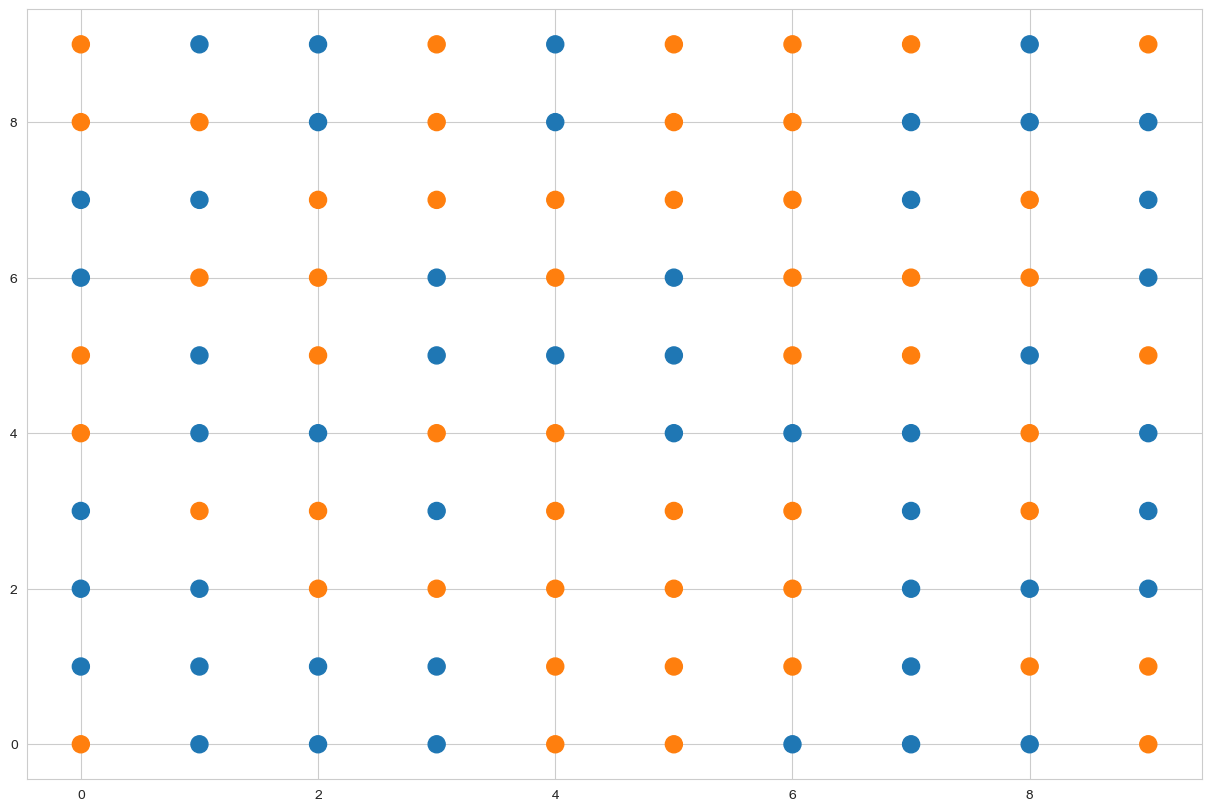

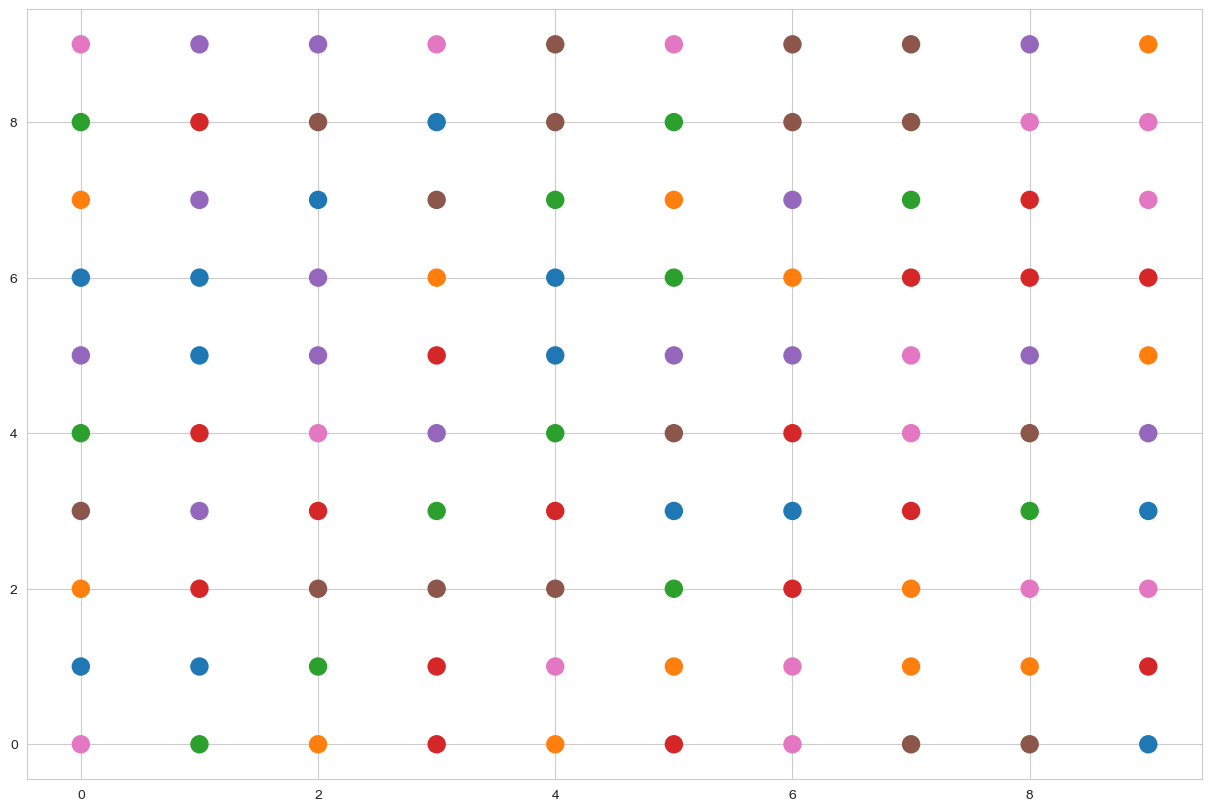

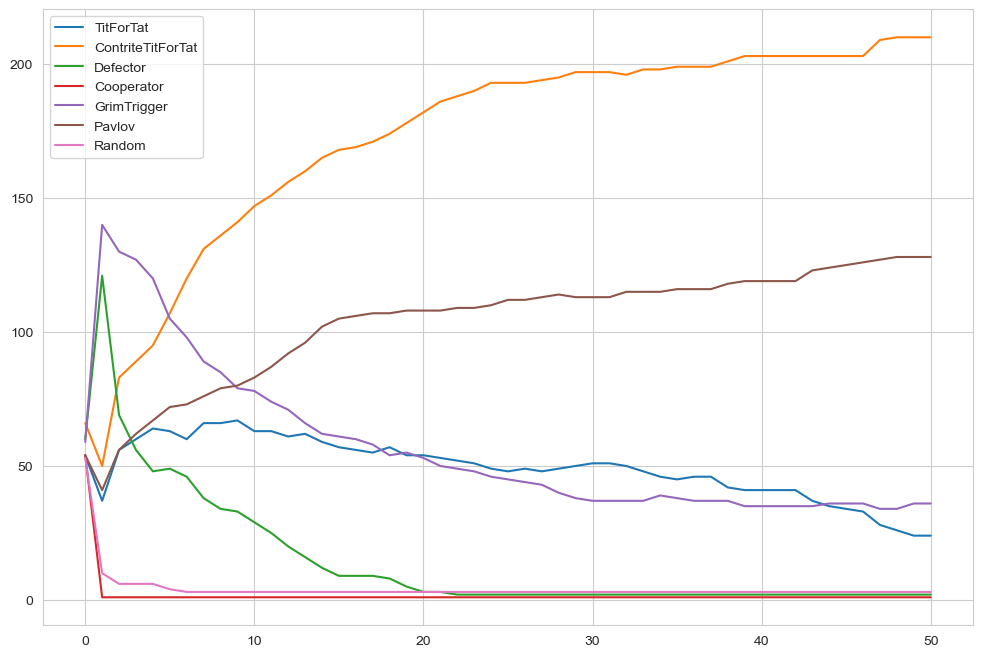

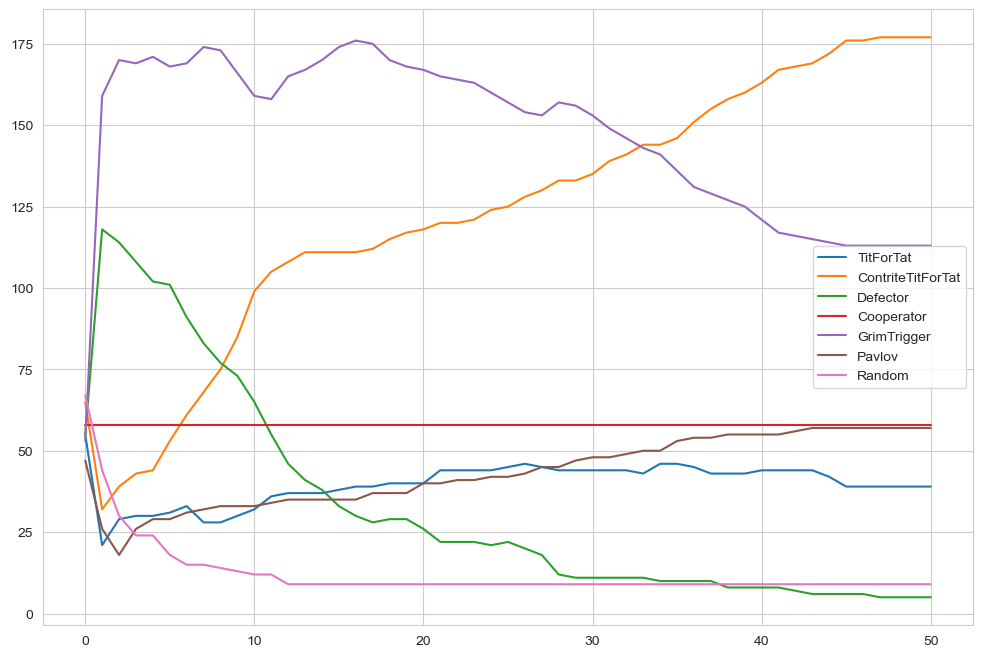

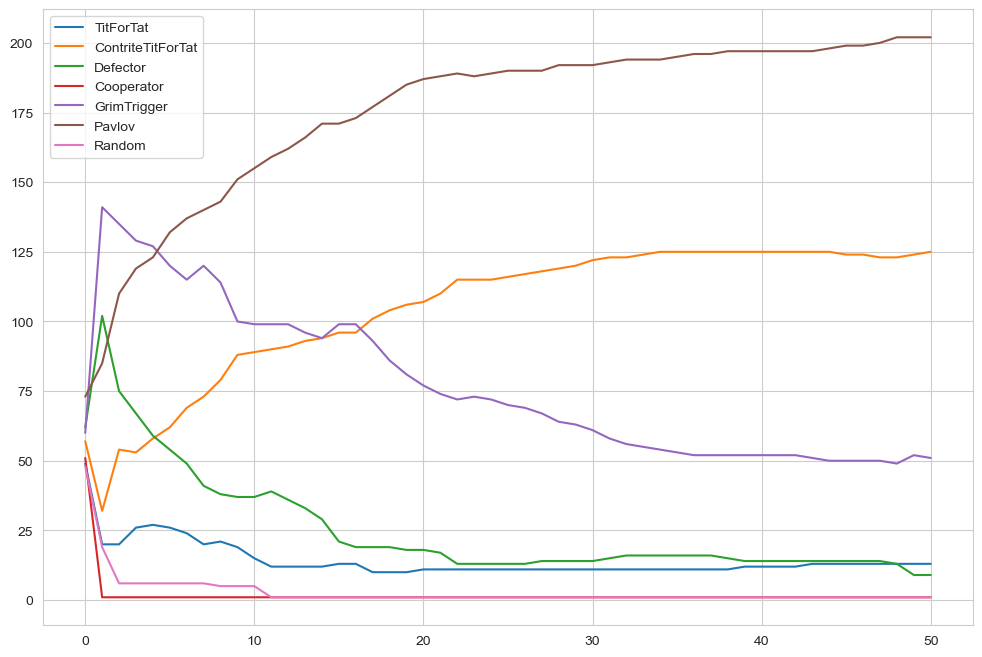

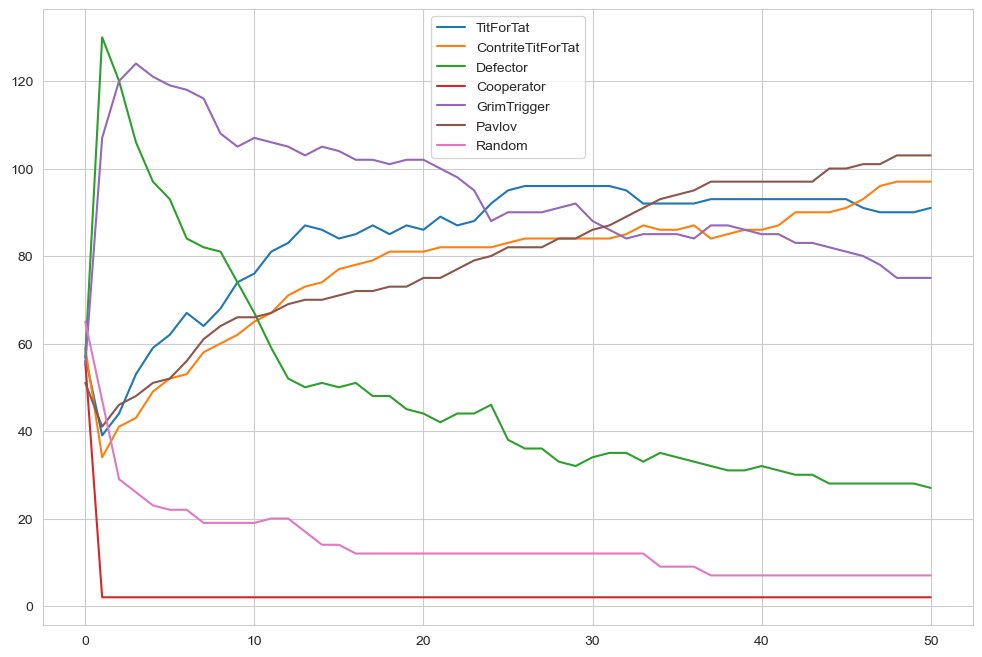

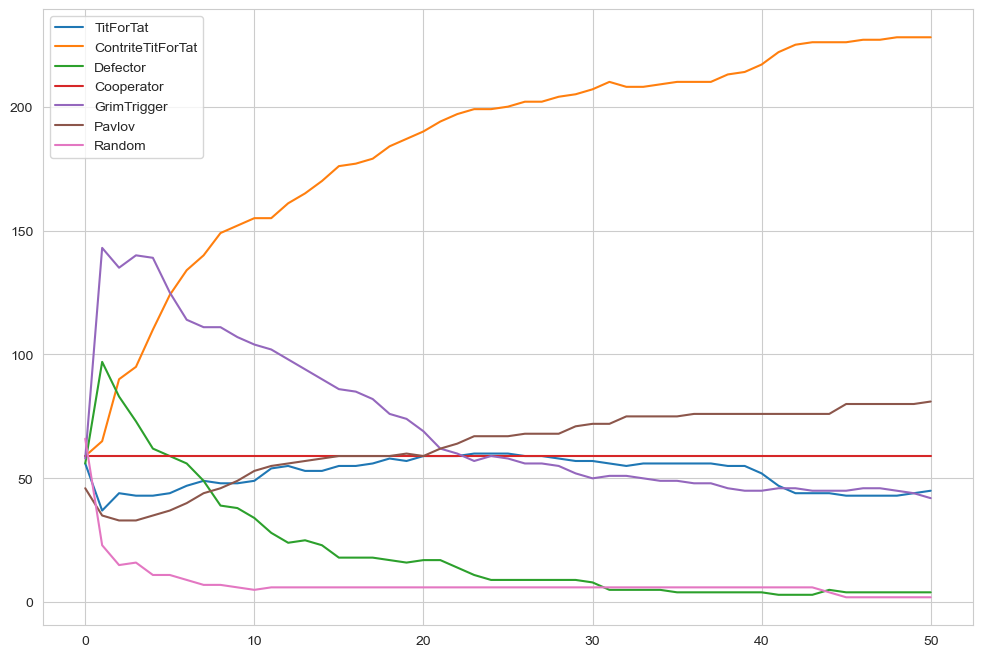

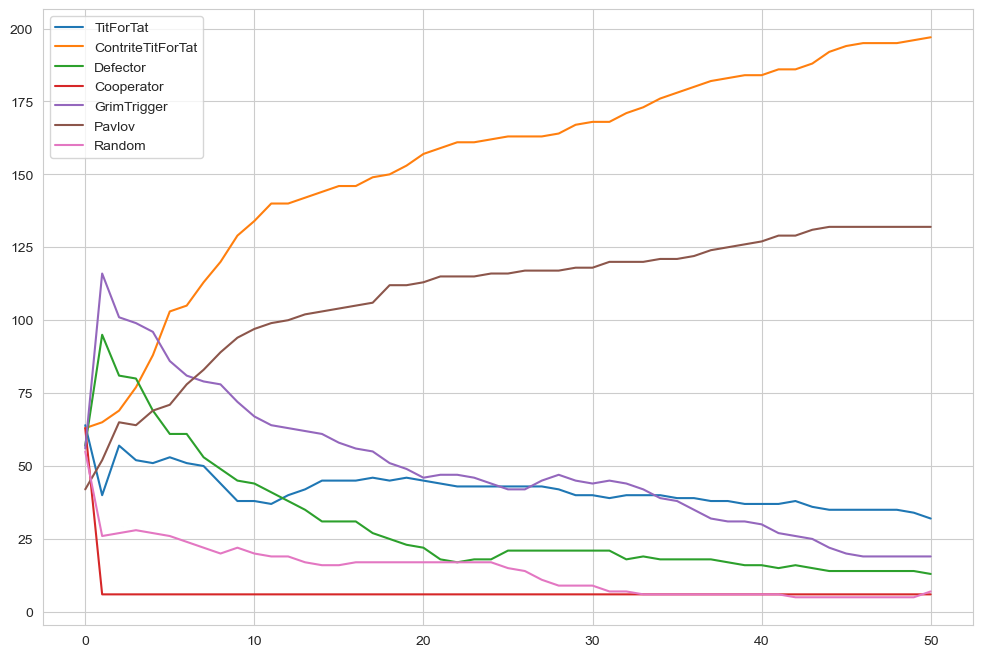

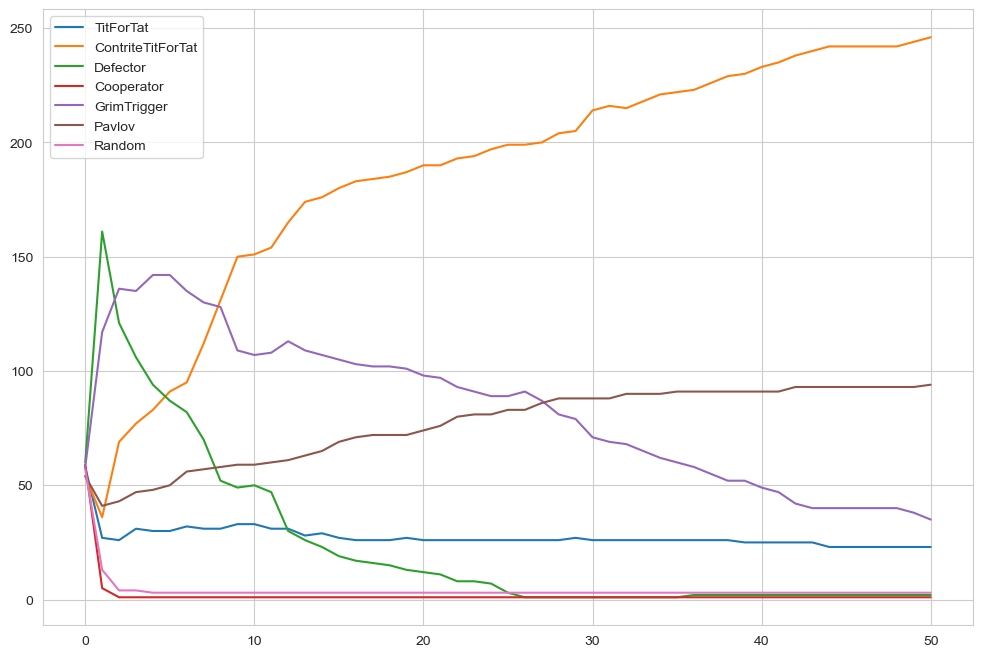

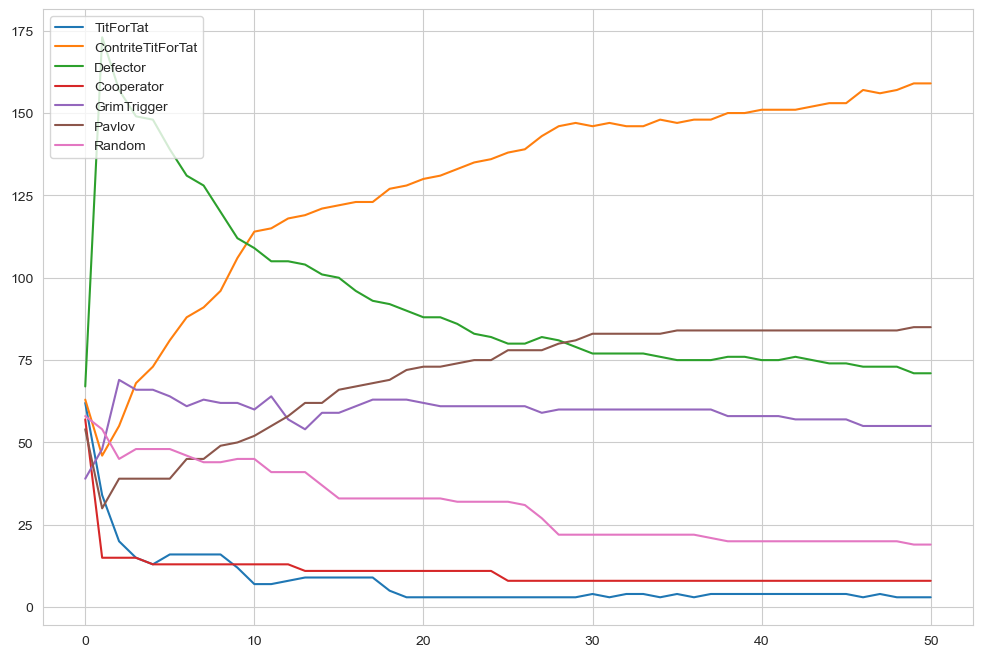

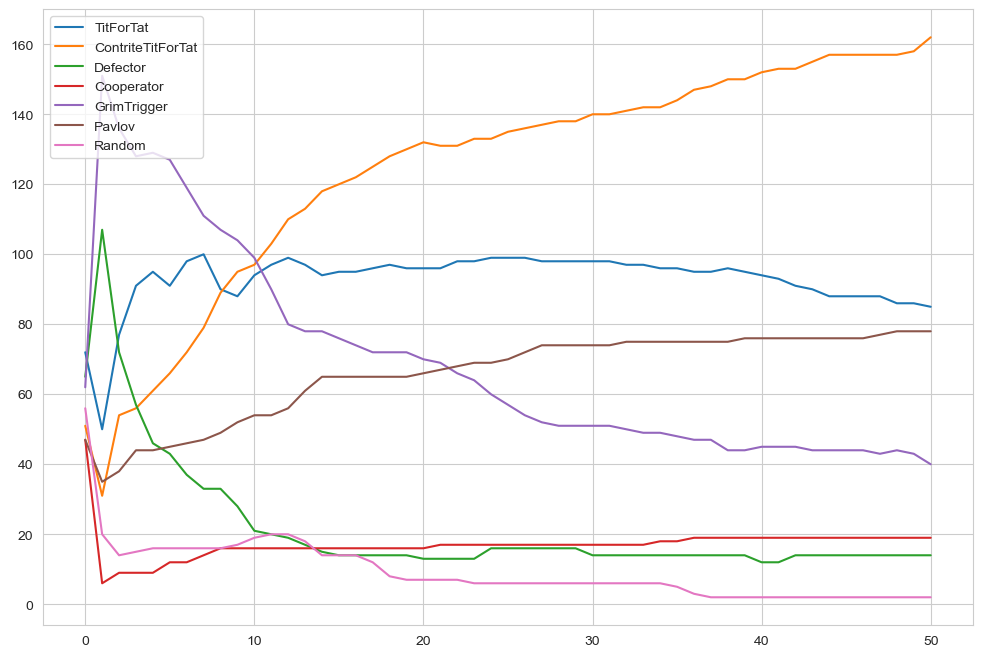

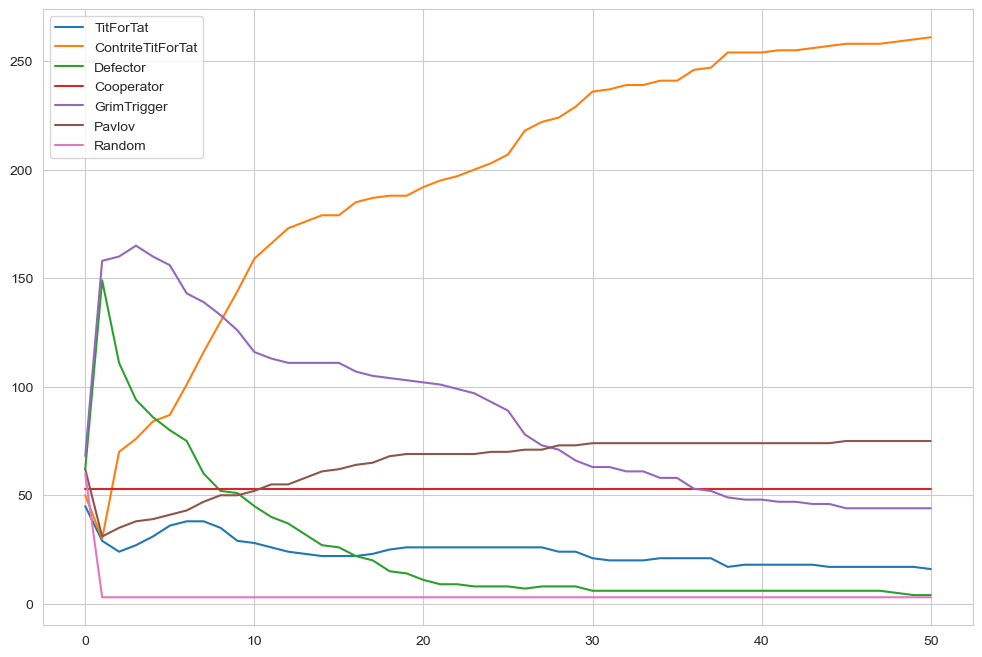

In [5]:
for _ in range(10):
    model = NoisySpatialEvolutionaryAxelrodModel(200)
    for _ in range(50):
        model.step()
    model.datacollector.get_model_vars_dataframe().plot()
    plt.show()